**<center>FA24 CS634101 Data Mining</center>**
**<center>saindane_sushil_finaltermproject</center>**
- This project aims to implement and evaluate various machine learning algorithms, including a deep learning model, to detect phishing URLs. Using the PhiUSIIL Phishing URL Dataset, we classify URLs as legitimate or phishing. I applied **Random Forest, Decision Tree, LSTM, and Bernoulli Naive Bayes**—the latter being effective for binary features.
- Each model was evaluated **with 10-fold cross-validation**, providing insights into their performance in phishing detection. This version captures the essence of your project in a brief format.

### Below are the detailed steps performed by the script in the following cell:

## Steps

1. **Load Dataset**
   - The script loads data from the PhiUSIIL Phishing URL Dataset located locally on the disk.
   - Displays basic information and the first few rows of the dataset to understand its structure.

2. **Preprocess Data**
   - A function `preprocess_chunk` is defined to handle data preprocessing:
     - **High-Cardinality Features**: Features like 'FILENAME', 'URL', and 'Domain' are transformed using `FeatureHasher` to reduce dimensionality.
     - **Low-Cardinality Features**: Features such as 'TLD' and 'Title' are one-hot encoded using `pd.get_dummies`.
     - **Numeric Features**: Numeric columns are selected, excluding the target label.
     - Combines all processed features into a feature matrix `X` and extracts labels `y`.

3. **Split Data**
   - The data is split into training and testing sets with an 80-20 split using `train_test_split`.

4. **Scale Features**
   - The features are scaled using `StandardScaler` to normalize them for better model performance.

5. **Save Preprocessed Data**
   - The preprocessed training and testing data (`X_train_scaled`, `X_test_scaled`, `y_train`, `y_test`) are saved as `.npy` files for later use.

## Output
- The script outputs the shapes of the training and testing sets after preprocessing.
- Saves the preprocessed data to disk for efficient loading in subsequent steps.

This preprocessing ensures that the dataset is ready for machine learning algorithms, enhancing model performance by handling feature dimensionality and scaling.


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import FeatureHasher

# Load the dataset
print("Loading the dataset...")
file_path = r"F:\SEM 3\CS634_DataMining\Final_Project\PhiUSIIL_Phishing_URL_Dataset.csv"
raw_data = pd.read_csv(file_path, nrows=50000)  # Load  50,000 rows
print("Dataset loaded. Shape:", raw_data.shape)

# Display basic information about the dataset
print("\nDataset Info:")
raw_data.info()

# Display the first few rows of the dataset
print("\nFirst few rows of the dataset:")
print(raw_data.head())

# Function to preprocess data
def preprocess_chunk(chunk):
    # Handle high-cardinality features
    high_cardinality_features = ['FILENAME', 'URL', 'Domain']
    hashed_features = []
    for feature in high_cardinality_features:
        hasher = FeatureHasher(n_features=100, input_type='string')
        hashed = hasher.transform([[str(val)] for val in chunk[feature]])
        hashed_features.append(hashed.toarray())
    
    # Handle low-cardinality features
    low_cardinality_features = ['TLD', 'Title']
    encoded_features = pd.get_dummies(chunk[low_cardinality_features], prefix=low_cardinality_features)
    
    # Select numeric features
    numeric_features = chunk.select_dtypes(include=[np.number]).drop('label', axis=1, errors='ignore')
    
    # Combine all features
    X = np.hstack([np.hstack(hashed_features), encoded_features, numeric_features])
    y = chunk['label'].values
    
    return X, y

# Process data
print("\nProcessing data...")
X, y = preprocess_chunk(raw_data)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing complete.")
print("Training set shape:", X_train_scaled.shape)
print("Testing set shape:", X_test_scaled.shape)

# Save preprocessed data
np.save('X_train_scaled.npy', X_train_scaled)
np.save('X_test_scaled.npy', X_test_scaled)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)
print("Preprocessed data saved.")


Loading the dataset...
Dataset loaded. Shape: (50000, 56)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 56 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   FILENAME                    50000 non-null  object 
 1   URL                         50000 non-null  object 
 2   URLLength                   50000 non-null  int64  
 3   Domain                      50000 non-null  object 
 4   DomainLength                50000 non-null  int64  
 5   IsDomainIP                  50000 non-null  int64  
 6   TLD                         50000 non-null  object 
 7   URLSimilarityIndex          50000 non-null  float64
 8   CharContinuationRate        50000 non-null  float64
 9   TLDLegitimateProb           50000 non-null  float64
 10  URLCharProb                 50000 non-null  float64
 11  TLDLength                   50000 non-null  int64  
 12  NoOfSubDomain  

# The below scripts perform the following algorithms:

1. **Random Forest**
2. **Decision Tree**
3. **LSTM**
4. **Bernoulli Naive Bayes**

## Workflow

1. **Data Preparation**
   - Loads the data from the PhiUSIIL Phishing URL Dataset.
   - Preprocess features: hash high-cardinality features and one-hot encode low-cardinality features.
   - Split data into training and testing sets, then scale features.

2. **Model Training**
   - Train Random Forest, Decision Tree, and LSTM using 10-fold cross-validation.
   - Train Bernoulli Naive Bayes on sampled data and binarized instances.

3. **Performance Evaluation**
   - Calculate metrics: Accuracy, Precision, Recall, F1-score, TPR, TNR, FPR, FNR, TSS, HSS for each algorithm.
   - Saves and prints metrics for each model.

This approach provides insights into the effectiveness of different models for phishing URL detection.


In [2]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from joblib import Parallel, delayed, Memory
from tqdm import tqdm
import os

# Joblib cache directory
cache_dir = './cache_dir'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

# Initialize joblib memory for caching
memory = Memory(location=cache_dir, verbose=0)

# Load data using joblib caching
@memory.cache
def load_data():
    X_train_scaled = np.load('X_train_scaled.npy')
    X_test_scaled = np.load('X_test_scaled.npy')
    y_train = np.load('y_train.npy')
    y_test = np.load('y_test.npy')
    return X_train_scaled, X_test_scaled, y_train, y_test

# Call the cached function to load data
X_train_scaled, X_test_scaled, y_train, y_test = load_data()

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    tss = tpr - fpr
    hss = 2 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) > 0 else 0
    
    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1,
        'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr,
        'TSS': tss, 'HSS': hss
    }

def train_and_evaluate(model, X_train, X_test, y_train, y_test, model_name):
    print(f"\nTraining and evaluating {model_name}...")
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    fold_metrics = []
    
    for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X_train), total=10, desc=f"{model_name} Folds")):
        X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
        y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
        
        if model_name == 'LSTM':
            X_fold_train = X_fold_train.reshape((X_fold_train.shape[0], 1, X_fold_train.shape[1]))
            X_fold_val = X_fold_val.reshape((X_fold_val.shape[0], 1, X_fold_val.shape[1]))
            model.fit(X_fold_train, y_fold_train, epochs=5, batch_size=32, verbose=0)
            y_pred = (model.predict(X_fold_val) > 0.5).astype(int).flatten()
        else:
            model.fit(X_fold_train, y_fold_train)
            y_pred = model.predict(X_fold_val)
        
        fold_metrics.append(calculate_metrics(y_fold_val, y_pred))
    
    # Calculate average metrics
    avg_metrics = {metric: np.mean([fold[metric] for fold in fold_metrics]) for metric in fold_metrics[0]}
    
    # Evaluate on test set
    if model_name == 'LSTM':
        X_test_reshaped = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
        y_pred_test = (model.predict(X_test_reshaped) > 0.5).astype(int).flatten()
    else:
        y_pred_test = model.predict(X_test)
    
    test_metrics = calculate_metrics(y_test, y_pred_test)
    
    return fold_metrics, avg_metrics, test_metrics

# Train Random Forest with parallelization
@memory.cache
def train_random_forest(X_train, X_test, y_train, y_test):
    print("\nTraining Random Forest...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    return train_and_evaluate(rf_model, X_train, X_test, y_train, y_test, 'Random Forest')

rf_fold_metrics, rf_avg_metrics, rf_test_metrics = train_random_forest(X_train_scaled, X_test_scaled, y_train, y_test)

# Train Decision Tree
@memory.cache
def train_decision_tree(X_train, X_test, y_train, y_test):
    print("\nTraining Decision Tree...")
    dt_model = DecisionTreeClassifier(random_state=42)
    return train_and_evaluate(dt_model, X_train, X_test, y_train, y_test, 'Decision Tree')

dt_fold_metrics, dt_avg_metrics, dt_test_metrics = train_decision_tree(X_train_scaled, X_test_scaled, y_train, y_test)

# Train LSTM
@memory.cache
def train_lstm(X_train, X_test, y_train, y_test):
    print("\nTraining LSTM...")
    lstm_model = Sequential([
        Input(shape=(1, X_train.shape[1])),
        LSTM(64),
        Dense(1, activation='sigmoid')
    ])
    lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return train_and_evaluate(lstm_model, X_train, X_test, y_train, y_test, 'LSTM')

lstm_fold_metrics, lstm_avg_metrics, lstm_test_metrics = train_lstm(X_train_scaled, X_test_scaled, y_train, y_test)

# Save results
np.save('rf_results.npy', {'fold_metrics': rf_fold_metrics, 'avg_metrics': rf_avg_metrics, 'test_metrics': rf_test_metrics})
np.save('dt_results.npy', {'fold_metrics': dt_fold_metrics, 'avg_metrics': dt_avg_metrics, 'test_metrics': dt_test_metrics})
np.save('lstm_results.npy', {'fold_metrics': lstm_fold_metrics, 'avg_metrics': lstm_avg_metrics, 'test_metrics': lstm_test_metrics})
print("Results saved.")

# Print average metrics for each model
for model_name, avg_metrics in [('Random Forest', rf_avg_metrics), ('Decision Tree', dt_avg_metrics), ('LSTM', lstm_avg_metrics)]:
    print(f"\nAverage metrics for {model_name}:")
    for metric, value in avg_metrics.items():
        print(f"{metric}: {value:.4f}")

# Print test metrics for each model
for model_name, test_metrics in [('Random Forest', rf_test_metrics), ('Decision Tree', dt_test_metrics), ('LSTM', lstm_test_metrics)]:
    print(f"\nTest metrics for {model_name}:")
    for metric, value in test_metrics.items():
        print(f"{metric}: {value:.4f}")



Training Random Forest...

Training and evaluating Random Forest...


Random Forest Folds: 100%|██████████| 10/10 [1:10:22<00:00, 422.24s/it]



Training Decision Tree...

Training and evaluating Decision Tree...


Decision Tree Folds: 100%|██████████| 10/10 [44:53<00:00, 269.38s/it]



Training LSTM...

Training and evaluating LSTM...


LSTM Folds:   0%|          | 0/10 [00:00<?, ?it/s]

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


LSTM Folds:  10%|█         | 1/10 [14:32<2:10:48, 872.10s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


LSTM Folds:  20%|██        | 2/10 [28:50<1:55:10, 863.77s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


LSTM Folds:  30%|███       | 3/10 [43:10<1:40:36, 862.29s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


LSTM Folds:  40%|████      | 4/10 [57:28<1:26:02, 860.38s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


LSTM Folds:  50%|█████     | 5/10 [1:11:44<1:11:34, 858.98s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


LSTM Folds:  60%|██████    | 6/10 [1:26:10<57:26, 861.51s/it]  

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


LSTM Folds:  70%|███████   | 7/10 [1:40:32<43:04, 861.50s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


LSTM Folds:  80%|████████  | 8/10 [1:54:50<28:40, 860.39s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


LSTM Folds:  90%|█████████ | 9/10 [2:09:00<14:17, 857.30s/it]

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


LSTM Folds: 100%|██████████| 10/10 [2:23:21<00:00, 860.17s/it]


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Results saved.

Average metrics for Random Forest:
TP: 2349.5000
TN: 1649.4000
FP: 1.1000
FN: 0.0000
Accuracy: 0.9997
Precision: 0.9995
Recall: 1.0000
F1-score: 0.9998
TPR: 1.0000
TNR: 0.9993
FPR: 0.0007
FNR: 0.0000
TSS: 0.9993
HSS: 0.9994

Average metrics for Decision Tree:
TP: 2349.5000
TN: 1650.5000
FP: 0.0000
FN: 0.0000
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
TPR: 1.0000
TNR: 1.0000
FPR: 0.0000
FNR: 0.0000
TSS: 1.0000
HSS: 1.0000

Average metrics for LSTM:
TP: 2349.3000
TN: 1554.4000
FP: 96.1000
FN: 0.2000
Accuracy: 0.9759
Precision: 0.9712
Recall: 0.9999
F1-score: 0.9832
TPR: 0.9999
TNR: 0.9405
FPR: 0.0595
FNR: 0.0001
TSS: 0.9404
HSS: 0.9447

Test metrics for Random Forest:
TP: 5879.0000
TN: 4117.0000
FP: 4.0000
FN: 0.0000
Accuracy: 0.9996
Precision: 0.9993
Recall: 1.0000
F1-score: 0.9997
TPR: 1.0000
TNR: 0.9990
FPR: 0.0010
FNR: 0.0000
TSS: 0.9990
HSS: 0.9992

Test metrics for Decision Tree:
TP: 5879.0000
TN: 4121

### Continuing with the Naive Bayes algorithm in the following script

In [91]:
import numpy as np
import pandas as pd
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.feature_extraction import FeatureHasher
from tqdm import tqdm

# Load and sample the dataset
file_path = r"F:\SEM 3\CS634_DataMining\Final_Project\PhiUSIIL_Phishing_URL_Dataset.csv"
data = pd.read_csv(file_path)
sampled_data = data.sample(n=20000, random_state=42)

# Preprocess the data
def preprocess_data(df):
    # Handle high-cardinality features
    high_cardinality_features = ['FILENAME', 'URL', 'Domain']
    hashed_features = []
    for feature in high_cardinality_features:
        hasher = FeatureHasher(n_features=100, input_type='string')
        hashed = hasher.transform([[str(val)] for val in df[feature]])
        hashed_features.append(hashed.toarray())
    
    # Handle low-cardinality features
    low_cardinality_features = ['TLD', 'Title']
    encoded_features = pd.get_dummies(df[low_cardinality_features], prefix=low_cardinality_features)
    
    # Select numeric features
    numeric_features = df.select_dtypes(include=[np.number]).drop('label', axis=1, errors='ignore')
    
    # Combine all features
    X = np.hstack([np.hstack(hashed_features), encoded_features, numeric_features])
    y = df['label'].values
    
    return X, y

X, y = preprocess_data(sampled_data)

# Binarize the features for Bernoulli NB
binarizer = Binarizer()
X_binarized = binarizer.fit_transform(X)

def calculate_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    tss = tpr - fpr
    hss = 2 * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) if ((tp + fn) * (fn + tn) + (tp + fp) * (fp + tn)) > 0 else 0
    
    return {
        'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn,
        'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-score': f1,
        'TPR': tpr, 'TNR': tnr, 'FPR': fpr, 'FNR': fnr,
        'TSS': tss, 'HSS': hss
    }

# Perform 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
bnb_fold_metrics = []

for fold, (train_index, val_index) in enumerate(tqdm(kf.split(X_binarized), total=10, desc="Bernoulli NB Folds")):
    X_fold_train, X_fold_val = X_binarized[train_index], X_binarized[val_index]
    y_fold_train, y_fold_val = y[train_index], y[val_index]
    
    bnb_model = BernoulliNB()
    bnb_model.fit(X_fold_train, y_fold_train)
    y_pred = bnb_model.predict(X_fold_val)
    
    bnb_fold_metrics.append(calculate_metrics(y_fold_val, y_pred))

# Calculate average metrics
bnb_avg_metrics = {metric: np.mean([fold[metric] for fold in bnb_fold_metrics]) for metric in bnb_fold_metrics[0]}

# Train on full dataset and test
bnb_model = BernoulliNB()
bnb_model.fit(X_binarized, y)
y_pred_test = bnb_model.predict(X_binarized)
bnb_test_metrics = calculate_metrics(y, y_pred_test)

# Save results
np.save('bnb_results.npy', {'fold_metrics': bnb_fold_metrics, 'avg_metrics': bnb_avg_metrics, 'test_metrics': bnb_test_metrics})
print("Bernoulli Naive Bayes results saved to 'bnb_results.npy'")

# Print average metrics
print("\nAverage metrics for Bernoulli Naive Bayes:")
for metric, value in bnb_avg_metrics.items():
    print(f"{metric}: {value:.4f}")

# Print test metrics
print("\nTest metrics for Bernoulli Naive Bayes:")
for metric, value in bnb_test_metrics.items():
    print(f"{metric}: {value:.4f}")


Bernoulli NB Folds: 100%|██████████| 10/10 [00:42<00:00,  4.23s/it]


Bernoulli Naive Bayes results saved to 'bnb_results.npy'

Average metrics for Bernoulli Naive Bayes:
TP: 1150.8000
TN: 822.0000
FP: 25.8000
FN: 1.4000
Accuracy: 0.9864
Precision: 0.9781
Recall: 0.9988
F1-score: 0.9883
TPR: 0.9988
TNR: 0.9696
FPR: 0.0304
FNR: 0.0012
TSS: 0.9684
HSS: 0.9720

Test metrics for Bernoulli Naive Bayes:
TP: 11511.0000
TN: 8239.0000
FP: 239.0000
FN: 11.0000
Accuracy: 0.9875
Precision: 0.9797
Recall: 0.9990
F1-score: 0.9893
TPR: 0.9990
TNR: 0.9718
FPR: 0.0282
FNR: 0.0010
TSS: 0.9709
HSS: 0.9743


# Model Performance Visualization and Comparison in Tabular Format

In the following script, we analyze and visualize the performance of four machine learning models:
Random Forest, Decision Tree, LSTM, and Naive Bayes.

## Key Functions:
1. `create_metrics_table`: Generates detailed performance metrics tables for each model.
2. `plot_confusion_matrix`: Creates confusion matrix heatmaps for visual analysis.

## Workflow:
1. Load pre-computed metrics for each model.
2. Generate and display performance tables for each model.
3. Plot confusion matrices for visual comparison.
4. Create a comprehensive comparison table of all models.

This analysis provides a thorough comparison of model performances across various metrics,
facilitating informed decision-making in model selection for phishing URL detection.



Random Forest Metrics:
+---------+------------+-------------+----------+------------+-------+--------+--------+-------+--------+--------+
| Fold    |   Accuracy |   Precision |   Recall |   F1-score |   TPR |    TNR |    FPR |   FNR |    TSS |    HSS |
+=========+============+=============+==========+============+=======+========+========+=======+========+========+
| Fold 1  |     0.9998 |      0.9996 |        1 |     0.9998 |     1 | 0.9994 | 0.0006 |     0 | 0.9994 | 0.9995 |
+---------+------------+-------------+----------+------------+-------+--------+--------+-------+--------+--------+
| Fold 2  |     1      |      1      |        1 |     1      |     1 | 1      | 0      |     0 | 1      | 1      |
+---------+------------+-------------+----------+------------+-------+--------+--------+-------+--------+--------+
| Fold 3  |     0.9998 |      0.9996 |        1 |     0.9998 |     1 | 0.9994 | 0.0006 |     0 | 0.9994 | 0.9995 |
+---------+------------+-------------+----------+-------

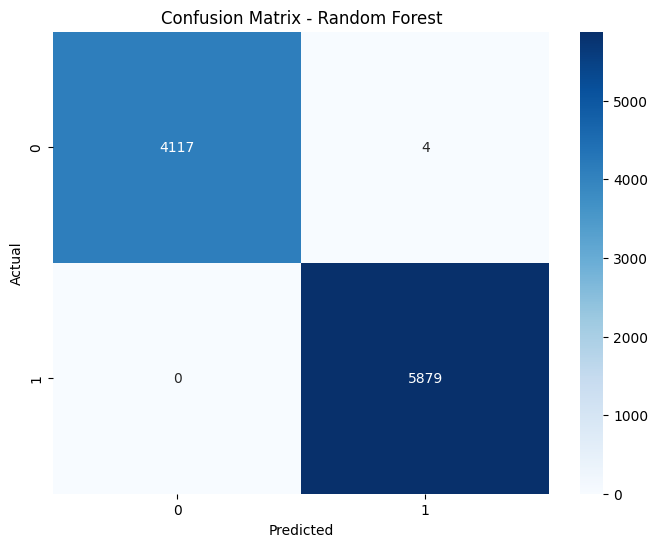


Decision Tree Metrics:
+---------+------------+-------------+----------+------------+-------+-------+-------+-------+-------+-------+
| Fold    |   Accuracy |   Precision |   Recall |   F1-score |   TPR |   TNR |   FPR |   FNR |   TSS |   HSS |
+=========+============+=============+==========+============+=======+=======+=======+=======+=======+=======+
| Fold 1  |          1 |           1 |        1 |          1 |     1 |     1 |     0 |     0 |     1 |     1 |
+---------+------------+-------------+----------+------------+-------+-------+-------+-------+-------+-------+
| Fold 2  |          1 |           1 |        1 |          1 |     1 |     1 |     0 |     0 |     1 |     1 |
+---------+------------+-------------+----------+------------+-------+-------+-------+-------+-------+-------+
| Fold 3  |          1 |           1 |        1 |          1 |     1 |     1 |     0 |     0 |     1 |     1 |
+---------+------------+-------------+----------+------------+-------+-------+-------+--

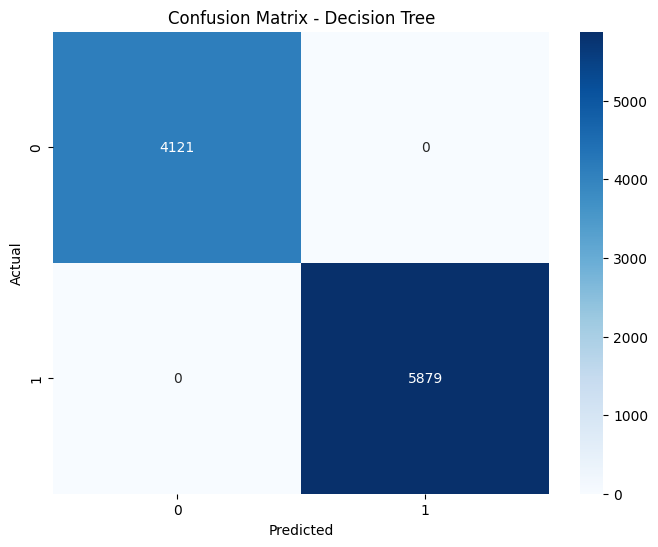


LSTM Metrics:
+---------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Fold    |   Accuracy |   Precision |   Recall |   F1-score |    TPR |    TNR |    FPR |    FNR |    TSS |    HSS |
+=========+============+=============+==========+============+========+========+========+========+========+========+
| Fold 1  |     0.7602 |      0.7133 |   1      |     0.8327 | 1      | 0.4058 | 0.5942 | 0      | 0.4058 | 0.449  |
+---------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Fold 2  |     0.9992 |      0.9996 |   0.9992 |     0.9994 | 0.9992 | 0.9994 | 0.0006 | 0.0008 | 0.9985 | 0.9984 |
+---------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Fold 3  |     1      |      1      |   1      |     1      | 1      | 1      | 0      | 0      | 1      | 1      |
+---------+------------+-------------+----------+

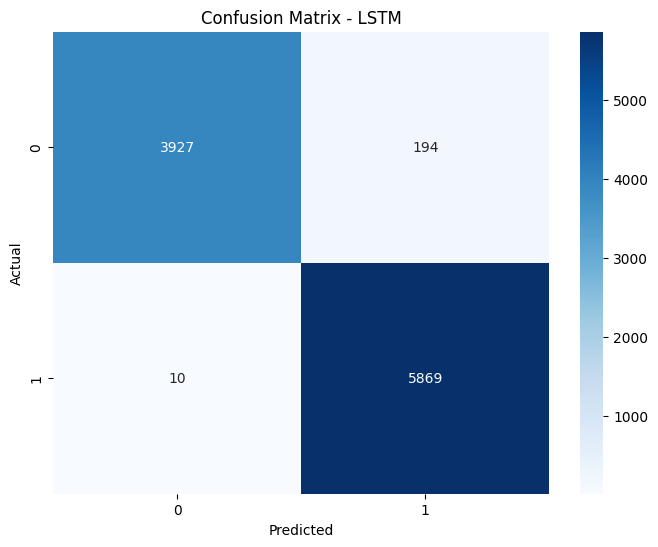


Naive Bayes Metrics:
+---------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Fold    |   Accuracy |   Precision |   Recall |   F1-score |    TPR |    TNR |    FPR |    FNR |    TSS |    HSS |
+=========+============+=============+==========+============+========+========+========+========+========+========+
| Fold 1  |     0.51   |      0.9286 |   0.0967 |     0.1751 | 0.0967 | 0.9913 | 0.0087 | 0.9033 | 0.088  | 0.082  |
+---------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Fold 2  |     0.49   |      1      |   0.1297 |     0.2296 | 0.1297 | 1      | 0      | 0.8703 | 0.1297 | 0.1098 |
+---------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Fold 3  |     0.518  |      1      |   0.1632 |     0.2806 | 0.1632 | 1      | 0      | 0.8368 | 0.1632 | 0.1419 |
+---------+------------+-------------+----

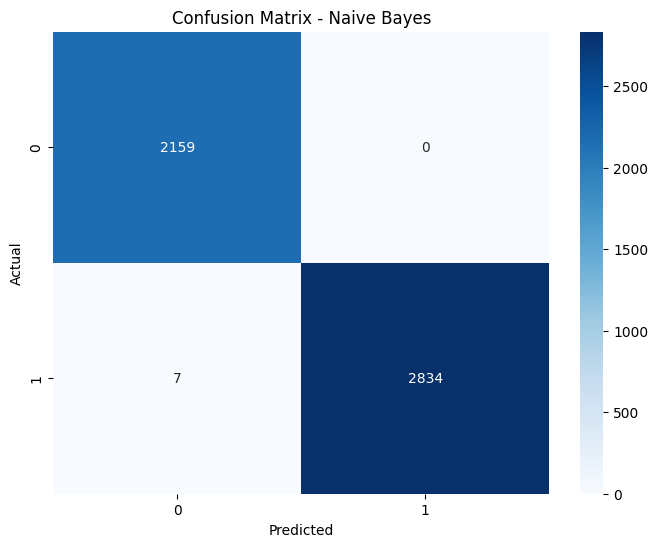


Comparison of Models:
+---------------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Model         |   Accuracy |   Precision |   Recall |   F1-score |    TPR |    TNR |    FPR |    FNR |    TSS |    HSS |
+===============+============+=============+==========+============+========+========+========+========+========+========+
| Random Forest |     0.9996 |      0.9993 |   1      |     0.9997 | 1      | 0.999  | 0.001  | 0      | 0.999  | 0.9992 |
+---------------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| Decision Tree |     1      |      1      |   1      |     1      | 1      | 1      | 0      | 0      | 1      | 1      |
+---------------+------------+-------------+----------+------------+--------+--------+--------+--------+--------+--------+
| LSTM          |     0.9796 |      0.968  |   0.9983 |     0.9829 | 0.9983 | 0.9529 | 0.0471 | 0.0017 | 0.9512 | 0.

In [93]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# Load saved metrics
rf_metrics = np.load('rf_results.npy', allow_pickle=True).item()
dt_metrics = np.load('dt_results.npy', allow_pickle=True).item()
lstm_metrics = np.load('lstm_results.npy', allow_pickle=True).item()
nb_metrics = np.load('nb_results.npy', allow_pickle=True).item()

# Extract fold, average, and test metrics
rf_fold_metrics = rf_metrics['fold_metrics']
rf_avg_metrics = rf_metrics['avg_metrics']
rf_test_metrics = rf_metrics['test_metrics']

dt_fold_metrics = dt_metrics['fold_metrics']
dt_avg_metrics = dt_metrics['avg_metrics']
dt_test_metrics = dt_metrics['test_metrics']

lstm_fold_metrics = lstm_metrics['fold_metrics']
lstm_avg_metrics = lstm_metrics['avg_metrics']
lstm_test_metrics = lstm_metrics['test_metrics']

nb_fold_metrics = nb_metrics['fold_metrics']
nb_avg_metrics = nb_metrics['avg_metrics']
nb_test_metrics = nb_metrics['test_metrics']

# Function to create tabular metrics
def create_metrics_table(fold_metrics, avg_metrics, test_metrics, model_name):
    table_data = []
    headers = ["Fold", "Accuracy", "Precision", "Recall", "F1-score", "TPR", "TNR", "FPR", "FNR", "TSS", "HSS"]
    
    for i, fold in enumerate(fold_metrics, 1):
        table_data.append([
            f"Fold {i}",
            f"{fold['Accuracy']:.4f}",
            f"{fold['Precision']:.4f}",
            f"{fold['Recall']:.4f}",
            f"{fold['F1-score']:.4f}",
            f"{fold['TPR']:.4f}",
            f"{fold['TNR']:.4f}",
            f"{fold['FPR']:.4f}",
            f"{fold['FNR']:.4f}",
            f"{fold['TSS']:.4f}",
            f"{fold['HSS']:.4f}"
        ])
    
    table_data.append([
        "Average",
        f"{avg_metrics['Accuracy']:.4f}",
        f"{avg_metrics['Precision']:.4f}",
        f"{avg_metrics['Recall']:.4f}",
        f"{avg_metrics['F1-score']:.4f}",
        f"{avg_metrics['TPR']:.4f}",
        f"{avg_metrics['TNR']:.4f}",
        f"{avg_metrics['FPR']:.4f}",
        f"{avg_metrics['FNR']:.4f}",
        f"{avg_metrics['TSS']:.4f}",
        f"{avg_metrics['HSS']:.4f}"
    ])
    
    table_data.append([
        "Test",
        f"{test_metrics['Accuracy']:.4f}",
        f"{test_metrics['Precision']:.4f}",
        f"{test_metrics['Recall']:.4f}",
        f"{test_metrics['F1-score']:.4f}",
        f"{test_metrics['TPR']:.4f}",
        f"{test_metrics['TNR']:.4f}",
        f"{test_metrics['FPR']:.4f}",
        f"{test_metrics['FNR']:.4f}",
        f"{test_metrics['TSS']:.4f}",
        f"{test_metrics['HSS']:.4f}"
    ])
    
    print(f"\n{model_name} Metrics:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

# Function to plot confusion matrix
def plot_confusion_matrix(test_metrics, model_name):
    cm = np.array([[test_metrics['TN'], test_metrics['FP']],
                   [test_metrics['FN'], test_metrics['TP']]])
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Create tables and confusion matrices
create_metrics_table(rf_fold_metrics, rf_avg_metrics, rf_test_metrics, "Random Forest")
plot_confusion_matrix(rf_test_metrics, "Random Forest")

create_metrics_table(dt_fold_metrics, dt_avg_metrics, dt_test_metrics, "Decision Tree")
plot_confusion_matrix(dt_test_metrics, "Decision Tree")

create_metrics_table(lstm_fold_metrics, lstm_avg_metrics, lstm_test_metrics, "LSTM")
plot_confusion_matrix(lstm_test_metrics, "LSTM")

create_metrics_table(nb_fold_metrics, nb_avg_metrics, nb_test_metrics, "Naive Bayes")
plot_confusion_matrix(nb_test_metrics, "Naive Bayes")

# Comparison table
comparison_data = [
    ["Model", "Accuracy", "Precision", "Recall", "F1-score", "TPR", "TNR", "FPR", "FNR", "TSS", "HSS"],
    ["Random Forest", f"{rf_test_metrics['Accuracy']:.4f}", f"{rf_test_metrics['Precision']:.4f}", 
     f"{rf_test_metrics['Recall']:.4f}", f"{rf_test_metrics['F1-score']:.4f}", 
     f"{rf_test_metrics['TPR']:.4f}", f"{rf_test_metrics['TNR']:.4f}", 
     f"{rf_test_metrics['FPR']:.4f}", f"{rf_test_metrics['FNR']:.4f}", 
     f"{rf_test_metrics['TSS']:.4f}", f"{rf_test_metrics['HSS']:.4f}"],
    ["Decision Tree", f"{dt_test_metrics['Accuracy']:.4f}", f"{dt_test_metrics['Precision']:.4f}", 
     f"{dt_test_metrics['Recall']:.4f}", f"{dt_test_metrics['F1-score']:.4f}", 
     f"{dt_test_metrics['TPR']:.4f}", f"{dt_test_metrics['TNR']:.4f}", 
     f"{dt_test_metrics['FPR']:.4f}", f"{dt_test_metrics['FNR']:.4f}", 
     f"{dt_test_metrics['TSS']:.4f}", f"{dt_test_metrics['HSS']:.4f}"],
    ["LSTM", f"{lstm_test_metrics['Accuracy']:.4f}", f"{lstm_test_metrics['Precision']:.4f}", 
     f"{lstm_test_metrics['Recall']:.4f}", f"{lstm_test_metrics['F1-score']:.4f}", 
     f"{lstm_test_metrics['TPR']:.4f}", f"{lstm_test_metrics['TNR']:.4f}", 
     f"{lstm_test_metrics['FPR']:.4f}", f"{lstm_test_metrics['FNR']:.4f}", 
     f"{lstm_test_metrics['TSS']:.4f}", f"{lstm_test_metrics['HSS']:.4f}"],
    ["Naive Bayes", f"{nb_test_metrics['Accuracy']:.4f}", f"{nb_test_metrics['Precision']:.4f}", 
     f"{nb_test_metrics['Recall']:.4f}", f"{nb_test_metrics['F1-score']:.4f}", 
     f"{nb_test_metrics['TPR']:.4f}", f"{nb_test_metrics['TNR']:.4f}", 
     f"{nb_test_metrics['FPR']:.4f}", f"{nb_test_metrics['FNR']:.4f}", 
     f"{nb_test_metrics['TSS']:.4f}", f"{nb_test_metrics['HSS']:.4f}"]
]

print("\nComparison of Models:")
print(tabulate(comparison_data, headers="firstrow", tablefmt="grid"))


**While most legitimate URLs look meaningful, many phishing URLs contain random alphabet, digits, and misspelled words that do not look meaningful. Often, an attacker uses the typosquatting technique to create a URL similar to a legitimate URL but with small typographical errors. 
To understand the pattern of each alphabet and digit in a URL, we count the occurrence of each alphabet and digit in the 10 million legitimate URLs and divide them by the total count of all alphabets and digits of 10 million legitimate URLs as shown below.**

**Displaying the probability comparison of alphabets and digits in legitimate URLs versus phishing URLs.**

In [40]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Load your dataset (replace with actual file path)
data = pd.read_csv("F:\SEM 3\CS634_DataMining\Final_Project\PhiUSIIL_Phishing_URL_Dataset.csv")

# Separate legitimate and phishing URLs
legitimate_urls = data[data['label'] == 1]['URL']
phishing_urls = data[data['label'] == 0]['URL']

# Function to count characters in URLs
def count_characters(urls):
    counter = Counter()
    for url in urls:
        counter.update(url)  # Update the counter with the current URL characters
    return counter

# Count characters for legitimate and phishing URLs
legitimate_count = count_characters(legitimate_urls)
phishing_count = count_characters(phishing_urls)

# Calculate total counts of letters and digits in each category
legitimate_total = sum(legitimate_count.values())
phishing_total = sum(phishing_count.values())

# Convert counts to DataFrames for easier manipulation
legitimate_df = pd.DataFrame(legitimate_count.items(), columns=['Character', 'Count'])
phishing_df = pd.DataFrame(phishing_count.items(), columns=['Character', 'Count'])

# Filter to keep only alphabets and digits
legitimate_df = legitimate_df[legitimate_df['Character'].str.isalnum()]
phishing_df = phishing_df[phishing_df['Character'].str.isalnum()]

# Add total counts and calculate probabilities
legitimate_df['Probability'] = legitimate_df['Count'] / legitimate_total
phishing_df['Probability'] = phishing_df['Count'] / phishing_total

# Merge the two DataFrames for comparison
comparison_df = pd.merge(
    legitimate_df[['Character', 'Probability']],
    phishing_df[['Character', 'Probability']],
    on='Character',
    suffixes=('_Legitimate', '_Phishing')
)

# Sort by character for better visualization
comparison_df.sort_values('Character', inplace=True)


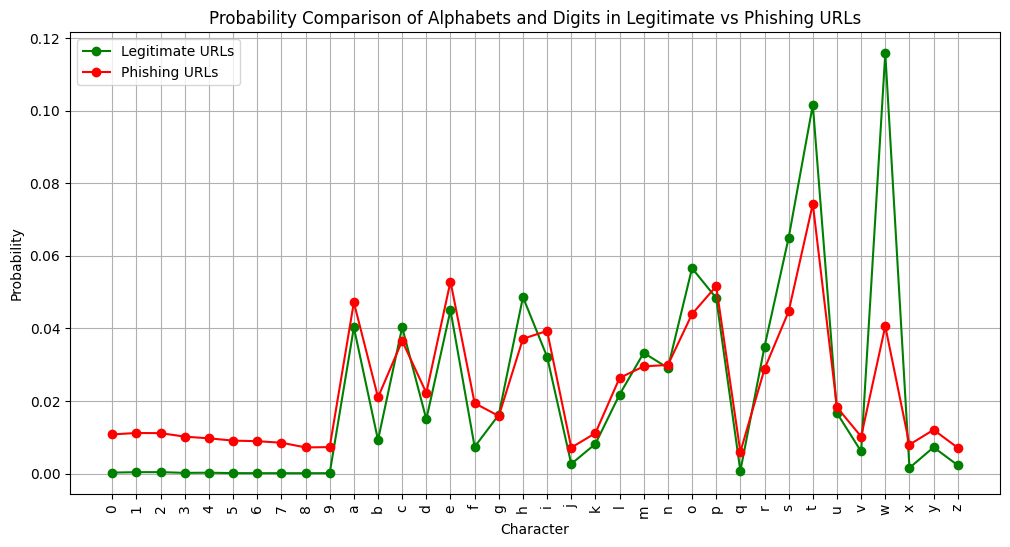

In [51]:
# Plotting the comparison
plt.figure(figsize=(12, 6))

# Line plot for probabilities
plt.plot(comparison_df['Character'], comparison_df['Probability_Legitimate'], marker='o', label='Legitimate URLs', color='green')
plt.plot(comparison_df['Character'], comparison_df['Probability_Phishing'], marker='o', label='Phishing URLs', color='red')

# Adding titles and labels
plt.title('Probability Comparison of Alphabets and Digits in Legitimate vs Phishing URLs')
plt.xlabel('Character')
plt.ylabel('Probability')
plt.xticks(comparison_df['Character'], rotation=90)
plt.legend()
plt.grid()
plt.show()


Loading the dataset...
Dataset loaded. Shape: (50000, 56)


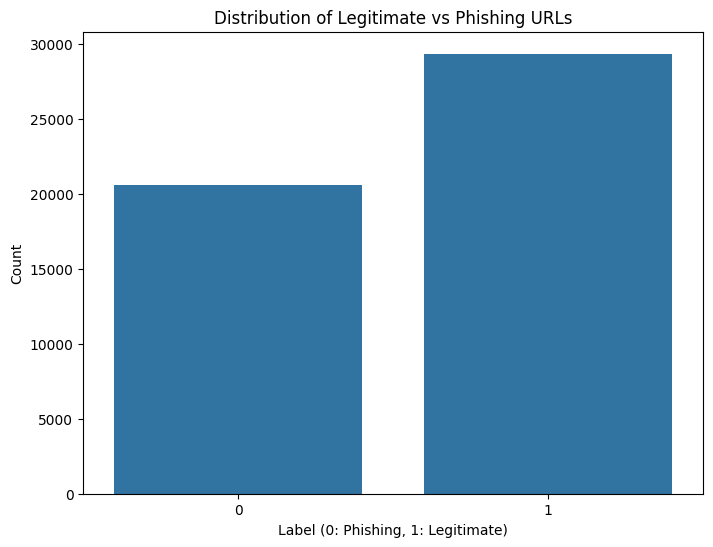

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
print("Loading the dataset...")
file_path = r"F:\SEM 3\CS634_DataMining\Final_Project\PhiUSIIL_Phishing_URL_Dataset.csv"
raw_data = pd.read_csv(file_path, nrows=50000)  # Load 50,000 rows
print("Dataset loaded. Shape:", raw_data.shape)

# Visualize distribution of target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=raw_data)
plt.title('Distribution of Legitimate vs Phishing URLs')
plt.xlabel('Label (0: Phishing, 1: Legitimate)')
plt.ylabel('Count')
plt.show()
